## Table of Contents
0. Initial Setup
1. Utility Functions
2. Load Networks and Metadata
   - 2.1 Load Unweighted and Weighted Graphs
   - 2.2 Load Metadata (School Group)
3. Community Detection
   - 3.1 Apply Louvain and Greedy Algorithms
4. Network Visualization
   - 4.1 Visualize Unweighted and Weighted Network with Community Colors
5. School Group Analysis
   - 5.1 Visualize Composition of Communities by School Group
6. Discussion
   - 6.1 Comparison Between Weighted and Unweighted Graphs
   - 6.2 Why Weights are Relevant
7. Conclusion


## 0. Initial Setup

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict, Counter
from tqdm import tqdm

# Community detection
import community as community_louvain
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

plt.style.use("ggplot")
%matplotlib inline

REPORT_FOLDER = "report"
PLOTS_FOLDER = "plots"
PARTITION_FOLDER = "partitions_clu"

for folder in [REPORT_FOLDER, PLOTS_FOLDER, PARTITION_FOLDER]:
    if not os.path.exists(folder):
        os.makedirs(folder)

!pip install scipy



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## 1. Utility Functions

In [27]:
def load_network(path):
    G = nx.read_pajek(path)
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    return G

def load_metadata(path):
    metadata = pd.read_csv(path, sep=" ", header=0)
    metadata.columns = ["Id", "class"]
    metadata["Id"] = metadata["Id"].astype(int) - 1
    return dict(zip(metadata["Id"], metadata["class"]))

def apply_greedy_community_detection(G, weight=None):
    """
    Applies the Greedy Modularity algorithm to the given graph.

    Parameters:
        G (networkx.Graph): The graph on which to run community detection.
        weight (str or None): Edge attribute to use as weight. If None, the graph is unweighted.

    Returns:
        list: A list of sets, where each set contains the nodes in one community.
    """
    return list(greedy_modularity_communities(G, weight=weight))

def save_partition_to_clu(partition, path, N=300):
    """
    Save a partition (list of sets) to a Pajek .clu file.

    Parameters:
        partition (list of sets): Detected communities.
        path (str): Output path to save the .clu file.
        N (int): Total number of nodes in the graph.
    """
    node_labels = [0] * N
    for i, community in enumerate(partition):
        for node in community:
            node_labels[node] = i + 1  # Pajek indexing starts from 1

    with open(path, 'w') as f:
        f.write(f"*Vertices {N}\n")
        for label in node_labels:
            f.write(f"{label}\n")

def draw_partitioned_graph(G, partition, layout, title, filename):
    colors = [
        '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
        '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
        '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
        '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080'
    ]
    node_color = [None] * G.number_of_nodes()
    for i, community in enumerate(partition):
        for node in community:
            node_color[node] = colors[i % len(colors)]
    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos=layout, node_color=node_color, node_size=50, alpha=0.9)
    nx.draw_networkx_edges(G, pos=layout, alpha=0.2)
    plt.title(title)
    plt.axis('off')
    plt.savefig(os.path.join(PLOTS_FOLDER, filename), bbox_inches='tight')
    plt.show()


## 2. Load Networks and Metadata
### 2.1 Load Unweighted and Weighted Graphs

In [28]:
unweighted_path = "data/primaryschool_u.net"
weighted_path = "data/primaryschool_w.net"

G_unweighted = load_network(unweighted_path)
G_weighted = load_network(weighted_path)

metadata_path = "data/metadata_primary_school.txt"
school_group = load_metadata(metadata_path)


### 3. Community Detection
#### 3.1 Apply Greedy Modularity Algorithm

In [29]:
greedy_partitions = {
    "unweighted": apply_greedy_community_detection(G_unweighted),
    "weighted": apply_greedy_community_detection(G_weighted, weight="weight")
}

# Save partitions to .clu files
for kind, partition in greedy_partitions.items():
    path = os.path.join(PARTITION_FOLDER, f"greedy_{kind}.clu")
    save_partition_to_clu(partition, path, N=G_unweighted.number_of_nodes())


## 4. Network Visualization
### 4.1 Visualize Unweighted and Weighted Network with Community Colors

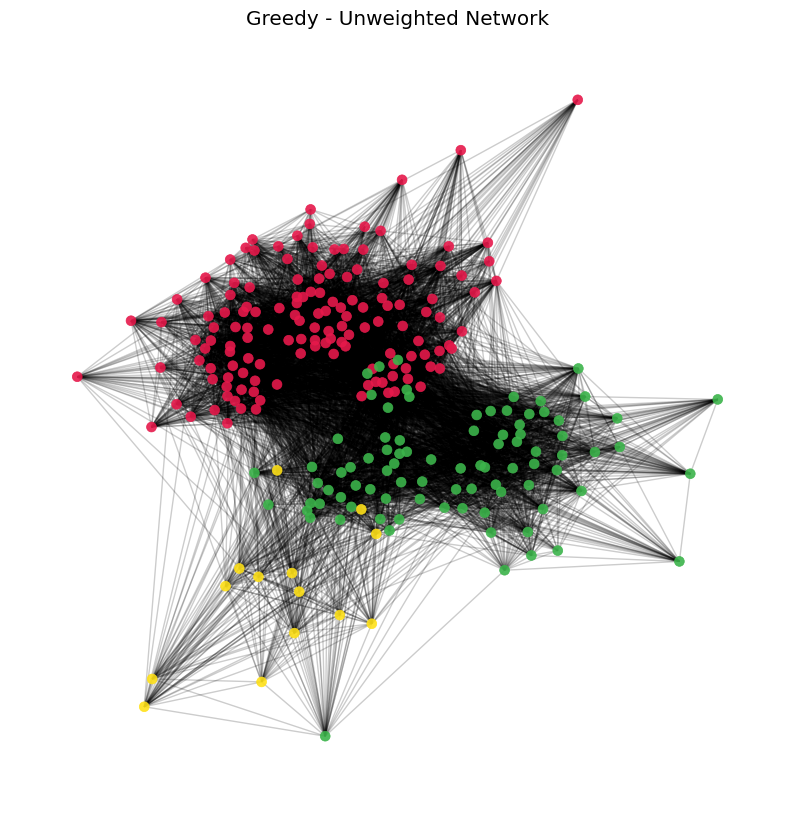

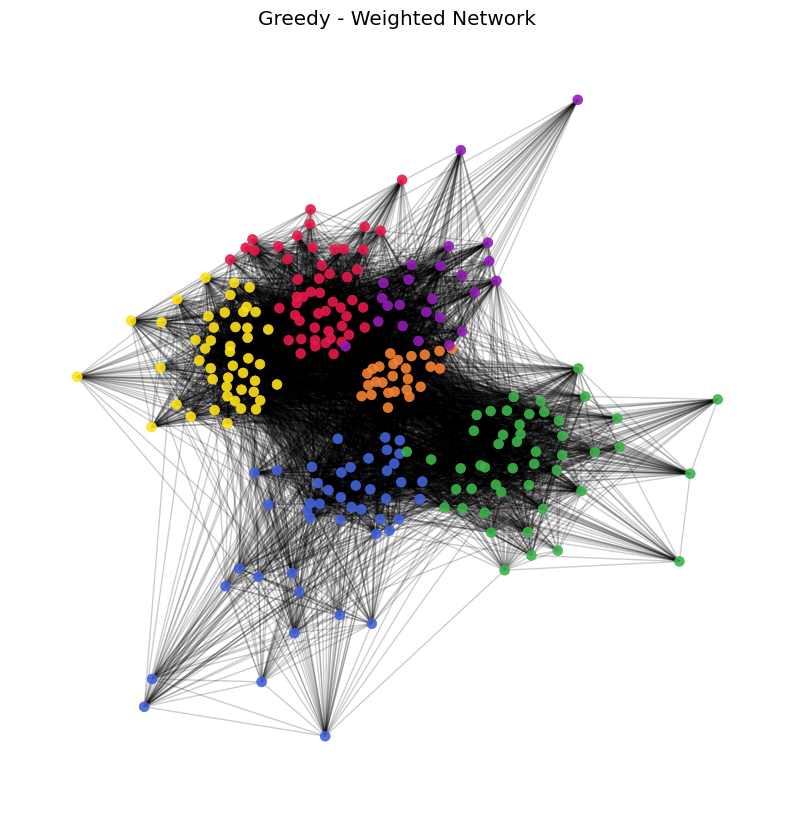

In [30]:
G_weighted_inv = G_weighted.copy()
for u, v, d in G_weighted_inv.edges(data=True):
    d['inv_weight'] = 1.0 / d['weight'] if d['weight'] > 0 else 0.0

layout = nx.kamada_kawai_layout(G_weighted_inv, weight="inv_weight")

draw_partitioned_graph(G_unweighted, greedy_partitions["unweighted"], layout,
                       "Greedy - Unweighted Network", "greedy_unweighted_network.png")

draw_partitioned_graph(G_weighted, greedy_partitions["weighted"], layout,
                       "Greedy - Weighted Network", "greedy_weighted_network.png")

## 5. School Group Analysis
### 5.1 Visualize Composition of Communities by School Group

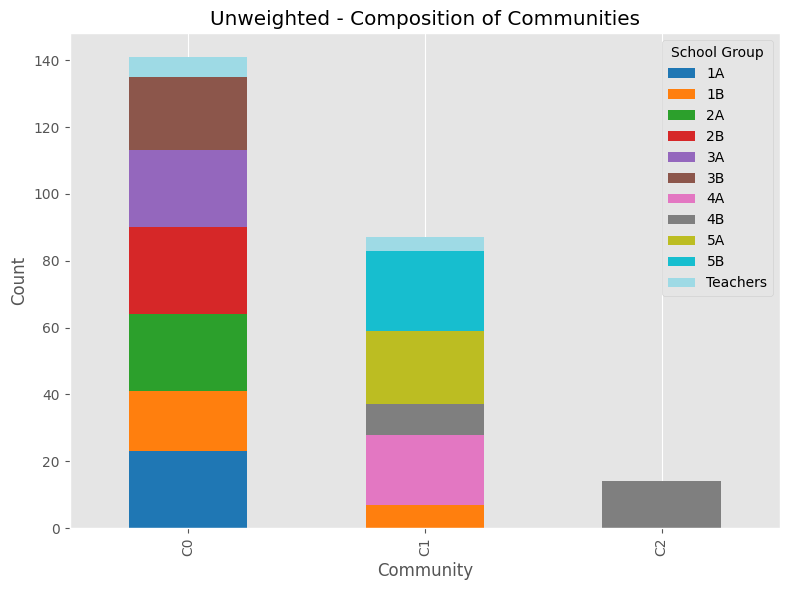

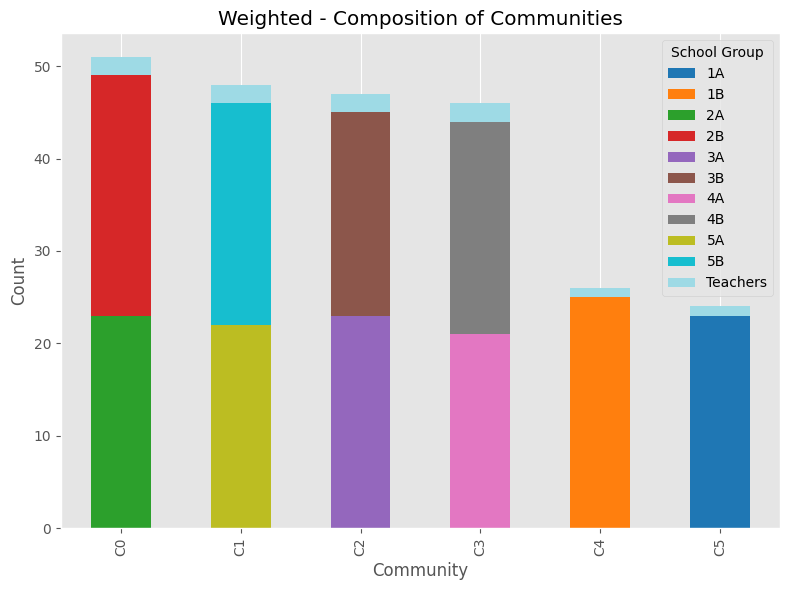

In [36]:
def compute_community_class_counts(partition, metadata):
    counts = []
    for i, community in enumerate(partition):
        class_counter = Counter(metadata[node] for node in community if node in metadata)
        for class_name, count in class_counter.items():
            counts.append({"Community": f"C{i}", "Class": class_name, "Count": count})
    return pd.DataFrame(counts)

unweighted_df = compute_community_class_counts(greedy_partitions["unweighted"], school_group)
weighted_df = compute_community_class_counts(greedy_partitions["weighted"], school_group)

for df, name in zip([unweighted_df, weighted_df], ["unweighted", "weighted"]):
    pivot_df = df.pivot(index="Community", columns="Class", values="Count").fillna(0)
    cmap = plt.colormaps.get_cmap('tab20')
    colors = cmap(np.linspace(0, 1, pivot_df.shape[1]))
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(8, 6), color=colors)
    ax.set_title(f"{name.capitalize()} - Composition of Communities")
    ax.set_ylabel("Count")
    ax.set_xlabel("Community")
    ax.legend(title="School Group")
    ax.grid(axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_FOLDER, f"school_group_composition_{name}.png"))
    plt.show()
